## Clothing Recommendation System Project

This Project is structured as follows:

1. Introduction
2. Loading the dataset
3. Data preparation and cleaning
4. Visualise samples by category 
5. Embedd images
6. Using cosine similarity to find similar images
7. Output examples of the recommendation system

### 1. Introduction 

The aim of this project is to build a reccomendation system that returns similar items of clothing (as images) for a chosen clothing image.

The following sources were used as a guide this project:
* https://thecleverprogrammer.com/2020/08/16/fashion-recommendation-system/
* https://www.analyticsvidhya.com/blog/2022/07/recommending-similar-images-using-image-embedding/

We start by importing packages.

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
import zipfile
from google.colab import drive
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances,cosine_similarity
import cv2 as cv
from tqdm.notebook import tqdm_notebook
import time
import os
import random

%matplotlib inline

### 2. Loading the datset 

Collect data into google drive, source: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

In [3]:
# clothing category (text)
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk'
output = 'clothing_category.txt'
gdown.download(url, output, quiet=False)

# image file name and clothing category label (numeric)
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk'
output = 'image_category.txt'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk
To: /content/clothing_category.txt
100%|██████████| 882/882 [00:00<00:00, 357kB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk
To: /content/image_category.txt
100%|██████████| 21.4M/21.4M [00:00<00:00, 122MB/s]


'image_category.txt'

In [4]:
# download the images
path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile('img.zip','r') as zip_ref:
    zip_ref.extractall(path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
100%|██████████| 2.68G/2.68G [00:18<00:00, 145MB/s]


### 3. Data Preparation and Cleaning

In [5]:
categories = []
image_paths = []

# category names (str)
with open('clothing_category.txt', 'r') as f:
  for line in f.readlines()[2:]:
    categories.append(line.split(' ')[0])

# category (numeric) and image filename
with open('image_category.txt', 'r') as f:
  for line in f.readlines()[2:]:
    image_paths.append([word.strip() for word in line.split(' ') if len(word) > 0]) 

# create dataframe of image path and category number 
df = pd.DataFrame(image_paths, columns = ['img_path', 'category_num'])
# ensure category number is a numeric type
df.category_num = pd.to_numeric(df.category_num)
# get the text category (anorak, blazer, etc) using the categories list
df['category'] = df.category_num.apply(lambda x: categories[int(x) - 1])
# drop number values for the category
df = df.drop('category_num', axis=1)

In [6]:
df

,img_path,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse
...,...,...
289217,img/Paisley_Print_Babydoll_Dress/img_00000050.jpg,Dress
289218,img/Paisley_Print_Babydoll_Dress/img_00000051.jpg,Dress
289219,img/Paisley_Print_Babydoll_Dress/img_00000052.jpg,Dress
289220,img/Paisley_Print_Babydoll_Dress/img_00000053.jpg,Dress


### 4. Visualise number of samples in each category

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <a list of 46 Text major ticklabel objects>)

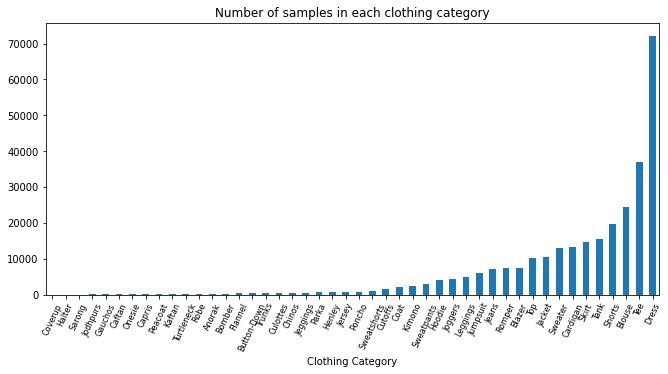

In [7]:
df.category.value_counts().sort_values().plot(kind='bar', figsize=(11,5))
plt.title('Number of samples in each clothing category')
plt.xlabel('Clothing Category')
plt.xticks(fontsize=8, rotation=65)


As we can see, the number of samples per clothing category varies greatly. Due to the computation time, for this project we will only consider a subset of the most frequent clothing category, Dress. In future work we will seek to include additional clothing categories. 

In [8]:
counts = df['category'].value_counts()
df = df[df['category'].map(counts)>40000]
df = df.sample(10000)

In [9]:
len(df)

10000

In [10]:
df.category.unique()

array(['Dress'], dtype=object)

In [11]:
df = df.drop('category', axis = 1)

### 5. Convert the images into embeddings

In [12]:
def image_embedding(model,img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    y_hat = model.predict(img_arr)
    embed_df = pd.DataFrame(y_hat[0]).T
    return embed_df

    
model = VGG16(include_top=False, weights='imagenet', pooling='avg')
img_path = df.img_path.iloc[42]
image_embedding(model,img_path)

1/1 [==============================] - 8s 8s/step


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.0,0.0,0.0,0.0,1.249768,2.644856,0.09646,0.0,2.89498,0.327398,...,0.0,3.224087,0.0,1.26508,0.0,0.0,0.0,1.780344,0.164622,3.395233


In [ ]:
img_path = df.img_path
embedding_df = pd.DataFrame()
for img in tqdm_notebook(img_path):
    embed_df = image_embedding(model,os.path.join('/content', img))
    embed_df['image'] = img
    embedding_df = pd.concat([embedding_df,embed_df],ignore_index=True)

In [17]:
embedding_df.to_csv('embedding_df.csv', index=False)

In [15]:
# for future use on new runtime without running the above
#embedding_df = pd.read_csv('embedding_df.csv')

### 6. Calculating cosine similarity to find similar images


In [18]:
cos_sim_df = pd.DataFrame(cosine_similarity(embedding_df.drop('image',axis=1)))

In [19]:
def show_img(image_name,title):
    img_path = os.path.join('/content', image_name)
    im = cv.imread(img_path)
    plt.axis('off')
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.show()

In [20]:
def fetch_most_similar_products(image_name,n_similar=7):
    print("-----------------------------------------------------------------------")
    print("Original Product:")
    show_img(image_name, image_name)
    curr_index = embedding_df[embedding_df['image']==image_name].index[0]
    closest_image = pd.DataFrame(cos_sim_df.iloc[curr_index].nlargest(n_similar+1)[1:])
    print("-----------------------------------------------------------------------")
    print("Recommended Product")
    for index,imgs in closest_image.iterrows():
        similar_image_name = embedding_df.iloc[index]['image']
        similarity = np.round(imgs.iloc[0],3)
        show_img(similar_image_name,str(similar_image_name)+' nSimilarity : '+str(similarity))


### 7. Output examples of the recommendation system

Example 1:

-----------------------------------------------------------------------
Original Product:


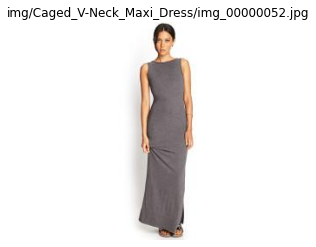

-----------------------------------------------------------------------
Recommended Product


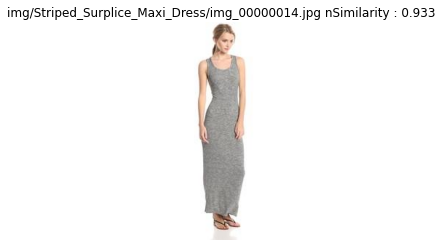

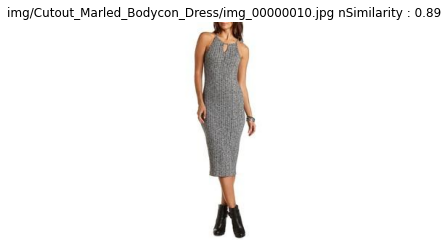

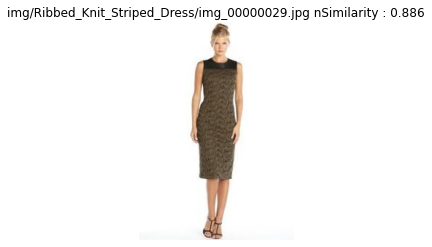

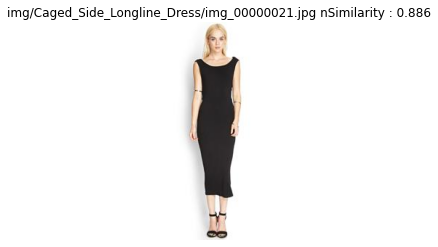

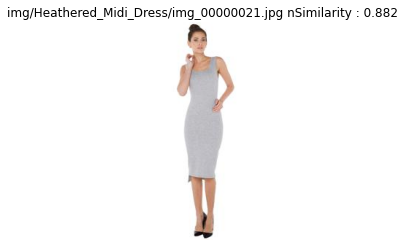

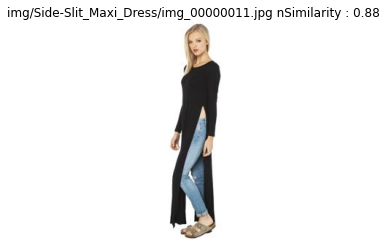

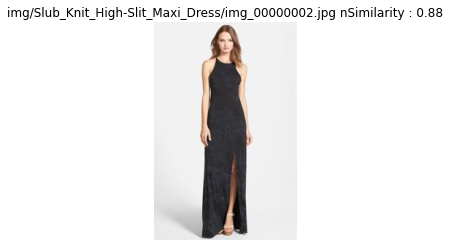

In [21]:
image_name = embedding_df.image.iloc[random.randint(0,len(embedding_df)-1)]
fetch_most_similar_products(image_name)

Example 2.

-----------------------------------------------------------------------
Original Product:


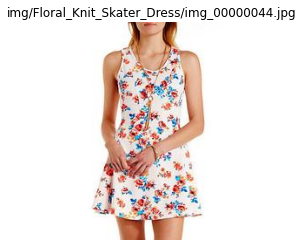

-----------------------------------------------------------------------
Recommended Product


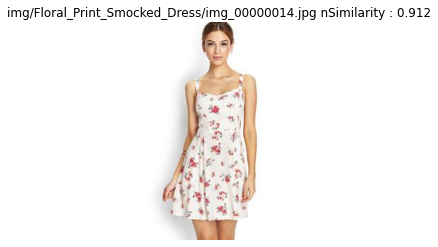

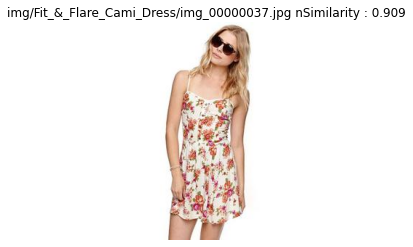

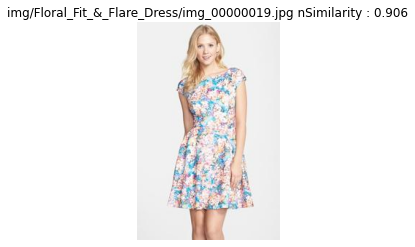

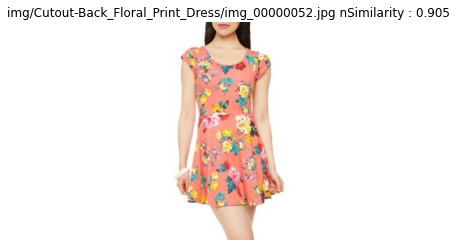

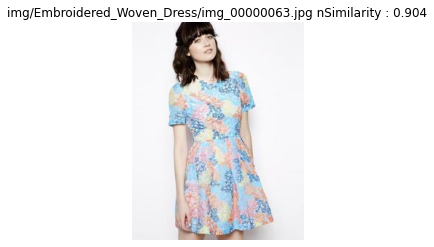

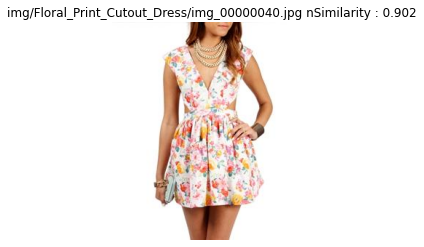

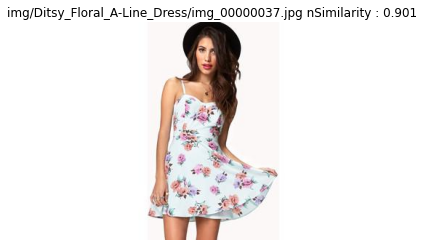

In [22]:
image_name = embedding_df.image.iloc[random.randint(0,len(embedding_df)-1)]
fetch_most_similar_products(image_name)

Example 3.

-----------------------------------------------------------------------
Original Product:


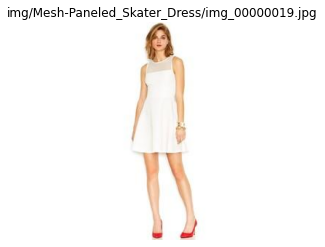

-----------------------------------------------------------------------
Recommended Product


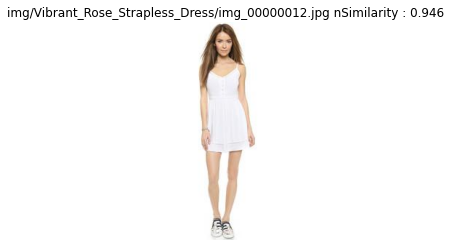

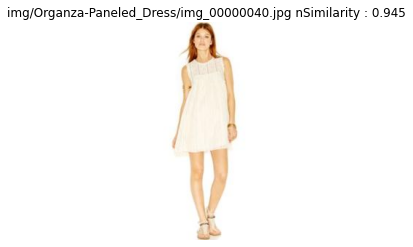

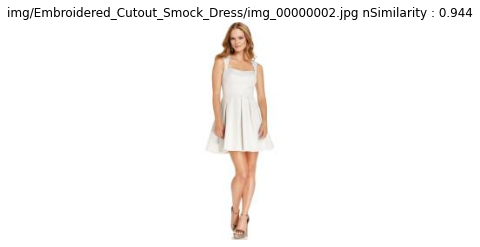

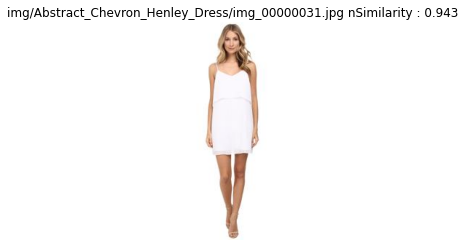

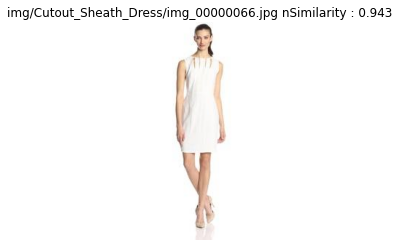

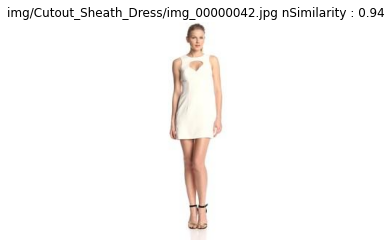

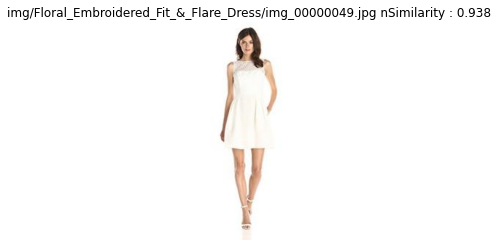

In [23]:
image_name = embedding_df.image.iloc[random.randint(0,len(embedding_df)-1)]
fetch_most_similar_products(image_name)

As we can see, the recommendation system returns products that are visually very similar to the original product. 